In [11]:
include("source.jl")
include("NS_FVM_solver.jl")

using Plots

In [12]:
N = (100,100) # 100 x 100 grid cells
UPC = 2 # Unknowns per grid cell, 2D so u,v
data_points = 20 # number of snapshots

dummy_data = rand(Normal(0,1),(N...,UPC,data_points)) # data_points


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC) # Generate fine mesh


J = (5,5) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J) # Generate a coarse mesh
MP = gen_mesh_pair(fine_mesh,coarse_mesh) # Struct which defines the mapping from fine to coarse
0



0

# Carry out local POD

In [30]:
POD_modes,S = carry_out_local_SVD(dummy_data,MP,subtract_average = conserve_momentum)

([-0.08445701797554905 0.07621907026464575 … -0.1335480382640177 0.08958447329404313; 0.31695303706943034 -0.17794705384133544 … -0.21872760334424715 0.2344166184637403; … ; -0.060216525550643385 -0.006914459759698892 … 0.0747837896546431 0.05776286501055435; -0.2013710709028007 0.1882037897319527 … -0.21957064703255816 -0.11449341159767963;;; 0.039286503390875374 0.12040394478396259 … 0.1986301929073653 -0.009777616708679382; 0.20288462677922744 -0.0782403591948156 … 0.031438400767051414 0.09000694868732989; … ; 0.07197522689078424 -0.002885946375271116 … -0.28815453023179155 0.18028313380571828; 0.055379279475628505 0.0597640610511919 … -0.10778467241895551 -0.035950219845818504;;;; 0.007035376652474898 -0.07739857155180997 … -0.40099892872789555 -0.16170386980080295; -0.06394865093362774 -0.03994246472051978 … -0.1595389673938752 -0.03371147496022811; … ; 0.3319924804304688 -0.03604539147669153 … 0.16781340729987834 -0.13278661747033146; -0.020047643279157777 0.15788955257140025 … 0

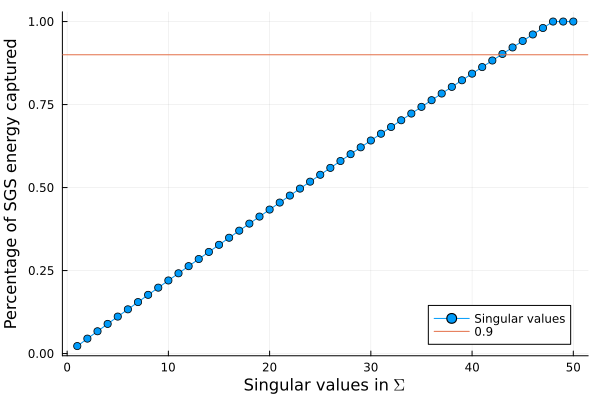

In [31]:
Plots.plot([sum(S[1:i]) for i in 1:size(S)[1]] ./ sum(S),marker = true,label = "Singular values")
hline!([0.9],label = "0.9")
xlabel!("Singular values in " * L"\Sigma")
ylabel!("Percentage of SGS energy captured")

# Local POD

We carry out the local POD and keep 10 modes per grid cell.
It transforms the full state vector into a reduced one 

$$\begin{bmatrix} \bar{\mathbf{u}}  \\ \bar{\mathbf{v}} \\ \mathbf{s}_1 \\ \vdots \\ \mathbf{s}_{8} \end{bmatrix}= \boldsymbol{\Phi}^T \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix}.$$

The first two modes in each grid cell, $\bar{\mathbf{u}}$ and $\bar{\mathbf{v}}$, can be interpreted as an averaged version of the solution.

In [33]:
r =10 #how many modes to include, including u_bar and v_bar
uniform = true


global_POD_modes = local_to_global_modes(POD_modes[:,:,:,1:(r-UPC)],MP)
global_POD_modes = add_filter_to_modes(global_POD_modes,MP,orthogonalize = !uniform) ## Adds filter the POD modes


PO = gen_projection_operators(global_POD_modes,MP,uniform =uniform)

projection_operators_struct(Conv((5, 5), 2 => 10, stride=5, bias=false), ConvTranspose((5, 5), 10 => 2, stride=5, bias=false), var"#W#858"{Array{Float64, 4}}(Core.Box(Conv((5, 5), 2 => 10, stride=5, bias=false)), [0.1999999984126683 0.1999999984126697 … 0.1999999984126697 0.1999999984126683; 0.1999999984126697 0.1999999984126711 … 0.1999999984126711 0.1999999984126697; … ; 0.1999999984126697 0.1999999984126711 … 0.1999999984126711 0.1999999984126697; 0.1999999984126683 0.1999999984126697 … 0.1999999984126697 0.1999999984126683;;; 0.1999999984126683 0.1999999984126697 … 0.1999999984126697 0.1999999984126683; 0.1999999984126697 0.1999999984126711 … 0.1999999984126711 0.1999999984126697; … ; 0.1999999984126697 0.1999999984126711 … 0.1999999984126711 0.1999999984126697; 0.1999999984126683 0.1999999984126697 … 0.1999999984126697 0.1999999984126683;;;;]), var"#R#859"{Array{Float64, 4}}(Core.Box(ConvTranspose((5, 5), 10 => 2, stride=5, bias=false)), [5.000000039683293 5.0000000396832585 … 5.0

In [34]:
a = PO.W(dummy_data) # Learned representation on coarse grid
u_and_v_bar = a[:,:,1:2,:] # First two modes ben be interpreted as an averaged version of u and v

20×20×2×20 Array{Float32, 4}:
[:, :, 1, 1] =
  0.292087     0.343587   -0.157979     …   0.0624584    0.151913
 -0.127997     0.0925067  -0.426245         0.0104628    0.119006
  0.301167    -0.784494    0.170789        -0.171984    -0.058566
 -0.277748     0.421456   -0.249895        -0.0381553    0.191437
 -0.065432     0.0410268  -0.0240368        0.0829718   -0.306985
  0.060528    -0.0518474   0.149655     …   0.0526392   -0.132596
 -0.329077    -0.0411286   0.0182542        0.0396919    0.228607
  0.0934976    0.338252    0.260134        -0.00363587   0.240064
 -0.467035    -0.0515452   0.128044         0.331328     0.00150369
 -0.153134    -0.0398896   0.134987        -0.328615     0.18269
 -0.0758869    0.113082    0.00904599   …   0.0981135   -0.0335116
 -0.311158     0.0767379   0.239182        -0.250529    -0.00892043
  0.0199183    0.0997987  -0.262173         0.100212     0.038999
 -0.268391     0.363171    0.105655         0.166636     0.147364
 -0.0638569    0.18881     

# Generate model

In [35]:


kernel_sizes= [(1,1),(1,1)]
channels = [r+2,50] # r+2 as the first channels are the coarse rhs
strides = [(1,1),(1,1)]
B = (1,1)
boundary_padding = "c" #[["c","c"];;[0,0]] # Circular padding is applied to the input for periodic boundary conditions


constrain_energy =true # whether to use a physics constrained NN or not
dissipation = true # include dissipation if physics is constrained
conserve_momentum =true # conserve momentum if physics is constrained


model = gen_skew_NN(kernel_sizes,channels,strides,r,B,boundary_padding = boundary_padding,UPC = coarse_mesh.UPC,constrain_energy = constrain_energy,dissipation = dissipation,conserve_momentum = conserve_momentum)
0

0

# Model prediction

Model is formulated as a matrix operation:

$$ \mathbf{c} = \mathbf{A}(\mathbf{a},\theta)\mathbf{a}$$

where the matrix $\mathbf{A}$ is constructed from the neural network.
The full model looks as follows 

$$ \frac{\text{d}\mathbf{a}}{\text{d}t} \approx \begin{bmatrix} f_H(\bar{\mathbf{u}},\bar{\mathbf{v}}) \\ \mathbf{0 } \end{bmatrix} + \mathbf{A}(\mathbf{a},\theta)\mathbf{a},$$

where $f_H$ is the coarse right hand side.

# What is missing?

We have the averaged quantities $\bar{\mathbf{u}}$ and $\bar{\mathbf{v}}$. However, in my code this lives on a cell centred grid. We also store a single flow snapshot in an array of dimension $N_x \times N_y \times \text{d}$, where $d=2$ is the number of spatial dimensions. However in syvers code these are all contained within a vector of dimension $N_x N_y d$. One way to solve this might by (in pseudocode):

In [21]:
function convert_to_Syvers_convention(input)
    return input
end
    
    
function map_to_staggered(input)
    return input
end
        

function compute_duv_dt(input)
    return input
end

function map_to_cell_centred(input)
    return input
end
            
            
            
function convert_to_Tobys_convention(input)
    return input
end
                



convert_to_Tobys_convention (generic function with 1 method)

In [36]:
# We have the u_bar and v_bar on a cell centred grid
uv_bar = a[:,:,1:2,:]

# We require:

#1 Convert to Syvers convenction
uv_bar_syver = convert_to_Syvers_convention(uv_bar)

#2 Map to staggered grid
uv_bar_syver_staggered = map_to_staggered(uv_bar_syver)

#3 Compute dVdt
duv_dt = compute_duv_dt(uv_bar_syver_staggered)

#4 map to cell centred grid
duv_dt_cell_centred = map_to_cell_centred(duv_dt)

#5 convert to Tobys convention
duv_dt_toby = convert_to_Tobys_convention(duv_dt_cell_centred)

#6 compute c
c = model.eval(cat(a,duv_dt_toby,dims = 3),a = padding(a,2 .* B,circular = true))

#Remaining stuff
0


0